## Useful libraries

In [226]:
import requests #used to send request to the API
import json #used to read the API response 
import pandas as pd #used to... Ok... You know, right?!
import psycopg2 #used to work with PostgreSQL
from sqlalchemy import create_engine 
import plotly.express as px
import datetime 
from plotly.subplots import make_subplots
import plotly.graph_objects as go

## First part - defining basic variables and functions
The goal of this part is to define some variables and functions that will be important during code execution.

In [2]:
#defining basic variables
base_url = 'https://dadosabertos.camara.leg.br/api/v2'
filter_url = '/deputados?ordem=ASC&ordenarPor=nome'

api_url = base_url + filter_url
api_url

#defining some basic functions
## This function will be used to request data and append to a list. Nothing fancy, by will simplify our code's readeability 
def getdata(link, explist):
    expenses = requests.get(link).json()
    return explist.append(expenses['dados'])

## This function will get the next link to the next page of our request stored in a dict (the default way python stores an API response)
def nextlinkfromdict(pdf):
    for row in pdf['links']:
        if row['rel'] == "next":
            return row['href']
    return None

## This function calls our previous function. You just have to send the link to the function and it will do the work. 
## I separated the two functions so I can use the remain dict from a previous call in the first function (so I don't over request the API).
## The default function is this one, though. 
def nextlinkfromurl(link):
    pdf = requests.get(link).json()
    return nextlinkfromdict(pdf)

In [3]:
response = requests.get(api_url)
deputadosdf = pd.DataFrame(response.json()['dados'])

In [5]:
## Getting more information 
i = 0
depdf = []

for i in range(0, len(deputadosdf)):
    print("Starting dep " + str(i+1))
    dep_filter_url = base_url + '/deputados/' + str(deputadosdf['id'][i])
    depdf.append(requests.get(dep_filter_url).json())

#merging the useful columns to the best dataframe
depdados = pd.DataFrame(list(pd.DataFrame(depdf)['dados']))
deputadosdf = deputadosdf.merge(depdados[['id', 'nomeCivil', 'cpf', 'sexo', 'dataNascimento', 'ufNascimento', 'municipioNascimento', 'escolaridade']], on = 'id')

Starting dep 1
Starting dep 2
Starting dep 3
Starting dep 4
Starting dep 5
Starting dep 6
Starting dep 7
Starting dep 8
Starting dep 9
Starting dep 10
Starting dep 11
Starting dep 12
Starting dep 13
Starting dep 14
Starting dep 15
Starting dep 16
Starting dep 17
Starting dep 18
Starting dep 19
Starting dep 20
Starting dep 21
Starting dep 22
Starting dep 23
Starting dep 24
Starting dep 25
Starting dep 26
Starting dep 27
Starting dep 28
Starting dep 29
Starting dep 30
Starting dep 31
Starting dep 32
Starting dep 33
Starting dep 34
Starting dep 35
Starting dep 36
Starting dep 37
Starting dep 38
Starting dep 39
Starting dep 40
Starting dep 41
Starting dep 42
Starting dep 43
Starting dep 44
Starting dep 45
Starting dep 46
Starting dep 47
Starting dep 48
Starting dep 49
Starting dep 50
Starting dep 51
Starting dep 52
Starting dep 53
Starting dep 54
Starting dep 55
Starting dep 56
Starting dep 57
Starting dep 58
Starting dep 59
Starting dep 60
Starting dep 61
Starting dep 62
Starting dep 63
S

In [202]:
deputadosdf['dataNascimento'] = pd.to_datetime(deputadosdf['dataNascimento'])
deputadosdf['age'] = round((pd.Timestamp.now().normalize() - deputadosdf['dataNascimento']).astype('timedelta64[Y]'),0)
df_sex = deputadosdf[['id', 'sexo']].groupby('sexo').count().reset_index()
df_sex['percentage'] = round(df_sex['id']/df_sex['id'].sum(), 2)
df_sex['percentage'] = df_sex['percentage'].map(lambda n: '{:.0%}'.format(n))
df_sex['sexo'].replace('F', 'Female',inplace=True)
df_sex['sexo'].replace('M', 'Male',inplace=True)

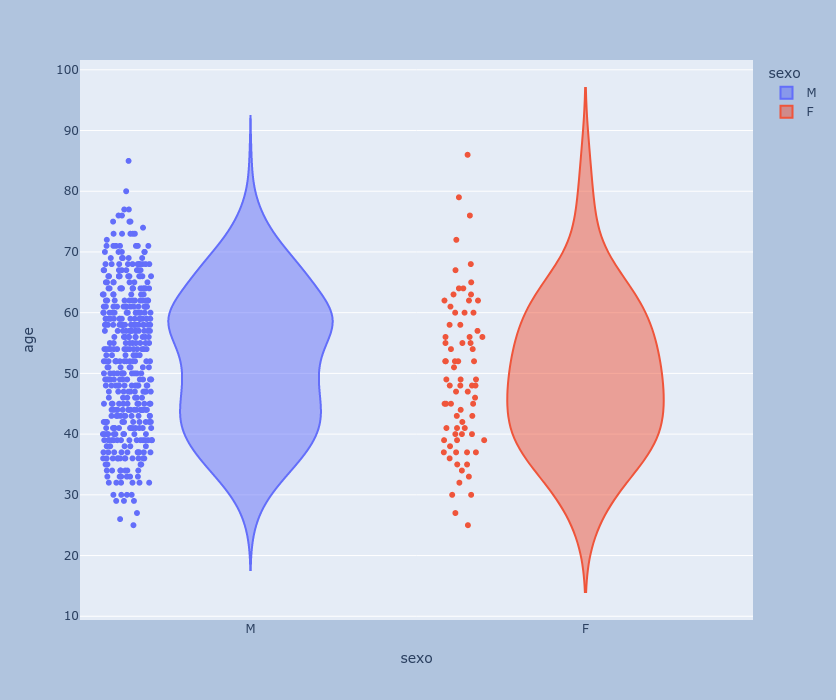

In [259]:
fig_group = px.violin(
    deputadosdf, 
    y="age", 
    x="sexo", 
    color="sexo", 
    points="all",
    hover_data=['nome'])

fig_group.update_layout(
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)

fig_group.show()

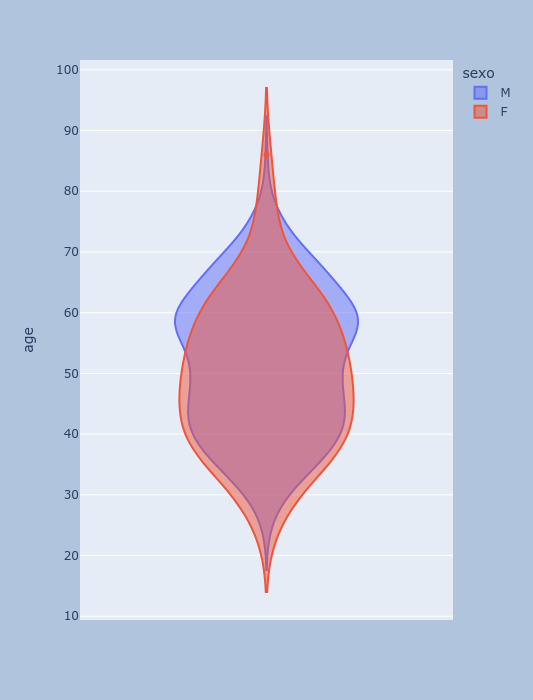

In [231]:
fig = px.violin(
    deputadosdf, 
    y="age", 
    color="sexo",
    violinmode='overlay')

fig.update_layout(
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)

fig.show()

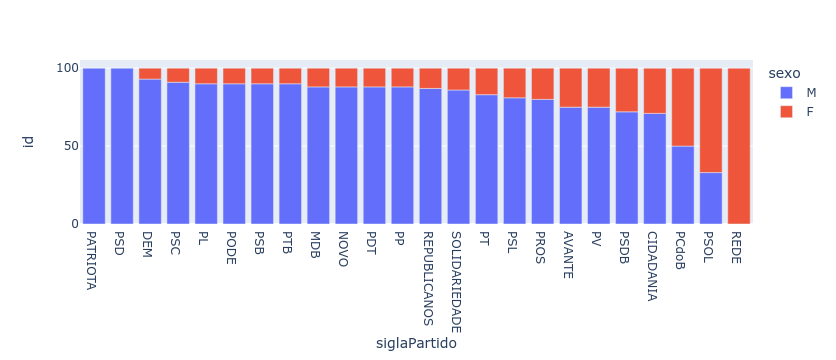

In [317]:
# fig_sc = px.scatter(deputadosdf, 
#                     x="siglaPartido", 
#                     y="age", 
#                     color="sexo")
# fig_sc.update_layout(height=700)
# fig_sc.show()

partsexdf = deputadosdf[['siglaPartido', 'sexo', 'id']]\
    .groupby(['siglaPartido','sexo'])\
    .agg({'id': 'count'})\
    .groupby(level=0)\
    .apply(lambda x: round(100*x/x.sum(),0))\
    .sort_values(['sexo','id'], ascending=False)\
    .reset_index()

partsexfig = px.bar(partsexdf, x='siglaPartido', y='id', color='sexo')

partsexfig.show()
# partsexdf

In [ ]:
## Getting more information
i = 0
desdf = []
deputadosdf['despesas'] = None

for i in range(0, len(deputadosdf)):
    listdesp = []
    dep_filter_url = base_url + '/deputados/' + str(deputadosdf['id'][i]) + '/despesas'
    listdesp.append(getdata(dep_filter_url, listdesp))
    next_url = nextlinkfromurl(dep_filter_url)
    print("Starting dep " + str(i+1))
    while(next_url is not None):
        nextlist = requests.get(next_url).json()
        listdesp.append(nextlist['dados'])
        next_url = nextlinkfromdict(nextlist)
    
    deputadosdf['despesas'][i] = listdesp
#     time.sleep(1)

#merging the useful columns to the best dataframe
# deputadosdf

In [ ]:
deputadosdf

In [169]:
def insert_into_table(dataframe, table):
    sql = "INSERT INTO deputados() VALUES(%s)"
    conn = None
    try:
        # read database configuration
        params = config()
        # connect to the PostgreSQL database
        conn = psycopg2.connect(**params)
        # create a new cursor
        cur = conn.cursor()
        # execute the INSERT statement
        cur.executemany(sql,vendor_list)
        # commit the changes to the database
        conn.commit()
        # close communication with the database
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()

db_string = "postgresql://yetusbwb@kesavan.db.elephantsql.com:5432/yetusbwb"
db = create_engine(db_string).raw_connection()
# conn = psycopg2.connect("dbname='yetusbwb' user='yetusbwb' host='kesavan.db.elephantsql.com'");
# cursor = conn.cursor()
# deputadosdf.drop(['despesas'], axis=1).to_sql('deputado', con=db, schema="yetusbwb",)
# conn.commit()
# cursor.close()
# conn.close()

DatabaseError: Execution failed on sql 'SELECT name FROM sqlite_master WHERE type='table' AND name=?;': relation "sqlite_master" does not exist
LINE 1: SELECT name FROM sqlite_master WHERE type='table' AND name=?...
                         ^


In [1]:
deputadosdf.drop(['despesas'], axis=1)

NameError: name 'deputadosdf' is not defined

In [79]:
pdf = requests.get(dep_filter_url).json()

def getnextlink(link):
    pdf = requests.get(link).json()
    for row in pdf['links']:
        if row['rel'] == "next":
            return row['href']
    return None
        
getnextlink('https://dadosabertos.camara.leg.br/api/v2/deputados/204554/despesas?pagina=10') is None

True

In [165]:
df = requests.get("https://dadosabertos.camara.leg.br/api/v2/deputados/204554/despesas?pagina=10&itens=15").json()

In [166]:
pdf = pd.DataFrame(df['links'])
if(len(pdf[pdf['rel'] == 'next']) == 0):
    print('True')
else:
    print('False')

True


1. REST API: Key Concepts, Best Practices, and Benefits [Online]. https://www.altexsoft.com/blog/rest-api-design/.
2. LEI Nº 12.527, DE 18 DE NOVEMBRO DE 2011. [Online]. http://www.planalto.gov.br/ccivil_03/_ato2011-2014/2011/lei/l12527.htm.
3. DADOS ABERTOS - CÂMARA DOS DEPUTADOS. [Online]. https://dadosabertos.camara.leg.br/swagger/api.html